# Clustering using numerical and categorical data : K-Prototypes

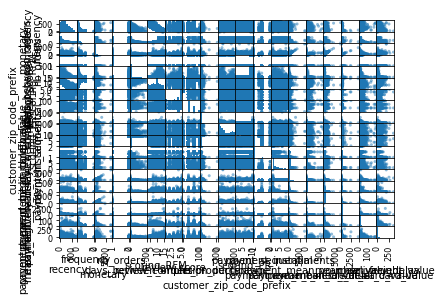

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split

customers = pd.read_csv("./../../../output/customers.csv")

customers.drop(columns=["first_order", "last_order"], inplace=True)
y = customers["review_score"]

X_train, X_test, y_train, y_test = train_test_split(
    customers, y, test_size=0.2, random_state=42, stratify=y
)
customers = X_test

pd.plotting.scatter_matrix(customers);

## Variables transformation from numerical to categorical

And what if we consider the frequency as a category ?

* It can be interesting to consider single order customers to the others ones.
* Also, we could consider customers who contribute reviews (title, message) from the one who don't.
* As monetary is really skewed, we may introduce bins.

Let's try this and see if we can have a better clustering after that !

In [2]:
customers

,recency,frequency,monetary,nb_orders,days_between_orders,scoring_RFM,segment_RFM,review_score,review_completion_percentage,review_behavior,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_mean_boleto_value,payment_mean_voucher_value,payment_mean_credit_card_value,payment_mean_debit_card_value,mean_delivery_delay,mean_freight_value
43517,450.0,0.062500,29.50,1.0,0,3,Clients tièdes,4.0,66.666667,Best Contributor,...,DF,5,1.0,1.0,0.000000,0.0,29.500000,0.0,8.0,12.60
52729,34.0,0.500000,72.07,1.0,0,12,Bons clients,5.0,100.000000,Best Contributor,...,SP,6,1.0,1.0,0.000000,0.0,72.070000,0.0,5.0,13.07
58266,468.0,0.058824,194.91,1.0,0,6,Clients tièdes,3.0,66.666667,Best Contributor,...,MG,6,1.0,1.0,0.000000,0.0,194.910004,0.0,5.0,15.01
7281,521.0,0.055556,47.95,1.0,0,3,Clients tièdes,5.0,33.333333,Best Contributor,...,ES,1,1.0,4.0,0.000000,0.0,47.950001,0.0,7.0,16.05
19387,225.0,0.125000,39.84,1.0,0,7,Bons clients,3.0,33.333333,Best Contributor,...,SP,2,1.5,1.5,0.000000,0.0,19.920000,0.0,20.0,11.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69873,137.0,0.166667,31.03,1.0,0,9,Bons clients,5.0,33.333333,Best Contributor,...,SP,7,1.0,1.0,0.000000,0.0,31.030001,0.0,4.0,8.88
77668,129.0,0.200000,111.42,1.0,0,11,Bons clients,5.0,100.000000,Best Contributor,...,SP,8,1.0,2.0,0.000000,0.0,111.419998,0.0,10.0,15.52
64782,192.0,0.142857,134.34,1.0,0,10,Bons clients,5.0,66.666667,Best Contributor,...,SP,7,1.0,1.0,134.339996,0.0,0.000000,0.0,3.0,14.44
72891,209.0,0.125000,43.09,1.0,0,7,Bons clients,5.0,33.333333,Best Contributor,...,SC,8,1.0,1.0,43.090000,0.0,0.000000,0.0,21.0,15.10


Let's plot the distribution of monetary :

In [3]:
customers.monetary.describe()

count    17628.000000
mean       149.954275
std        201.480774
min         10.890000
25%         60.860000
50%        102.030000
75%        171.872500
max       7274.880000
Name: monetary, dtype: float64

## Using K-Prototype clustering method

We have to evaluate the right number of clusters even if we are confident it's around **5** as stated by our previous experiments.

In [4]:
# Prepare variables for transformation and remove useless ones
transformed_customers = customers.copy()
transformed_customers = transformed_customers.drop(
    columns=["review_completion_percentage", "nb_orders"]
)
transformed_customers.loc[
    transformed_customers.review_score == 0, "review_score"
] = 1e-5

transformed_customers.head()

,recency,frequency,monetary,days_between_orders,scoring_RFM,segment_RFM,review_score,review_behavior,nb_products,customer_zip_code_prefix,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_mean_boleto_value,payment_mean_voucher_value,payment_mean_credit_card_value,payment_mean_debit_card_value,mean_delivery_delay,mean_freight_value
43517,450.0,0.062500,29.50,0,3,Clients tièdes,4.0,Best Contributor,1,72110,...,DF,5,1.0,1.0,0.0,0.0,29.500000,0.0,8.0,12.60
52729,34.0,0.500000,72.07,0,12,Bons clients,5.0,Best Contributor,1,19700,...,SP,6,1.0,1.0,0.0,0.0,72.070000,0.0,5.0,13.07
58266,468.0,0.058824,194.91,0,6,Clients tièdes,3.0,Best Contributor,1,30770,...,MG,6,1.0,1.0,0.0,0.0,194.910004,0.0,5.0,15.01
7281,521.0,0.055556,47.95,0,3,Clients tièdes,5.0,Best Contributor,1,29645,...,ES,1,1.0,4.0,0.0,0.0,47.950001,0.0,7.0,16.05
19387,225.0,0.125000,39.84,0,7,Bons clients,3.0,Best Contributor,1,17120,...,SP,2,1.5,1.5,0.0,0.0,19.920000,0.0,20.0,11.85


In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

# Pre-processing
for feature in transformed_customers.select_dtypes(
    exclude=["object", "category"]
).columns:
    pipeline = make_pipeline(StandardScaler(), PowerTransformer())

    transformed_customers[feature] = pipeline.fit_transform(
        np.array(transformed_customers[feature]).reshape(-1, 1)
    )

transformed_customers.head()

,recency,frequency,monetary,days_between_orders,scoring_RFM,segment_RFM,review_score,review_behavior,nb_products,customer_zip_code_prefix,...,customer_state,scoring_PR,payment_sequential,payment_installments,payment_mean_boleto_value,payment_mean_voucher_value,payment_mean_credit_card_value,payment_mean_debit_card_value,mean_delivery_delay,mean_freight_value
43517,1.339335,-1.241583,-1.547634,-0.143858,-1.860716,Clients tièdes,-0.767771,Best Contributor,-0.364254,1.254198,...,DF,-0.169919,-0.185434,-0.898961,-0.507301,-0.209093,-0.689045,-0.134012,-0.323932,-0.646510
52729,-1.501040,1.668124,-0.585197,-0.143858,0.990640,Bons clients,0.812790,Best Contributor,-0.364254,-0.353341,...,SP,0.180174,-0.185434,-0.898961,-0.507301,-0.209093,0.021192,-0.134012,-0.997033,-0.553506
58266,1.425773,-1.321532,0.933795,-0.143858,-0.917053,Clients tièdes,-1.305636,Best Contributor,-0.364254,0.171505,...,MG,0.180174,-0.185434,-0.898961,-0.507301,-0.209093,1.113031,-0.134012,-0.997033,-0.200332
7281,1.671855,-1.394013,-1.097483,-0.143858,-1.860716,Clients tièdes,0.812790,Best Contributor,-0.364254,0.124290,...,ES,-1.569865,-0.185434,1.147725,-0.507301,-0.209093,-0.355118,-0.134012,-0.532281,-0.030908
19387,0.064487,-0.125278,-1.288916,-0.143858,-0.601350,Bons clients,-1.305636,Best Contributor,-0.364254,-0.494748,...,SP,-1.219926,5.392765,-0.287048,-0.507301,-0.209093,-0.878849,-0.134012,1.132964,-0.801049


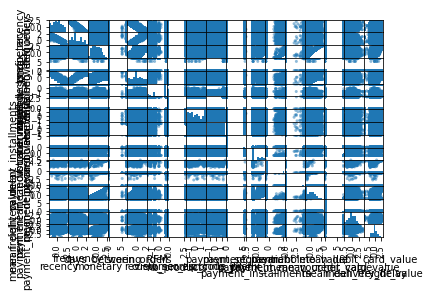

In [6]:
pd.plotting.scatter_matrix(pd.DataFrame(transformed_customers));

In [7]:
from kmodes.kprototypes import KPrototypes

costs = []

for n_clusters in list(range(2, 10)):
    k_prototypes = KPrototypes(n_clusters=n_clusters, random_state=42, n_jobs=-1)
    k_prototypes.fit_predict(transformed_customers, categorical=[8, 10, 13, 14])
    costs.append({"n_clusters": n_clusters, "cost": k_prototypes.cost_})

pd.DataFrame(costs).plot(title="Cost per number of clusters", x="n_clusters", y="cost");

ValueError: could not convert string to float: 'Clients tièdes'

In [ ]:
import seaborn as sns
from sklearn import metrics

k_prototypes = KPrototypes(n_clusters=5, random_state=42, n_jobs=-1)

customers["cluster"] = k_prototypes.fit_predict(
    transformed_customers, categorical=[8, 10, 13, 14]
)
customers["cluster"] = customers.cluster.astype("category")

print(customers["cluster"].value_counts())

sns.pairplot(customers, hue="cluster", palette="Dark2", diag_kind="kde");

## Clustering visualisation

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# Create dummies for categorical variables
df = pd.get_dummies(
    pd.DataFrame(transformed_customers),
    prefix="",
    prefix_sep="",
    columns=transformed_customers.select_dtypes(include=["object", "category"]).columns,
)

print(
    "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, customers["cluster"])
)

tsne = TSNE(n_components=2, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter(
    projected_customers,
    x=0,
    y=1,
    color=customers.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [ ]:
tsne = TSNE(n_components=3, learning_rate="auto", init="random", n_jobs=-1)

projected_customers = tsne.fit_transform(df)

fig = px.scatter_3d(
    projected_customers,
    x=0,
    y=1,
    z=2,
    color=customers.cluster,
    labels={"color": "cluster"},
    opacity=0.8,
)
fig.show()

In [ ]:
print("END")